In [14]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int
from utils import u_plot as uplot
import glob

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [13]:
cd ..

/home/ck/pythonWorkspace


In [3]:
gpm_folder = cnst.network_data + 'data/OBS/IMERG_HQ_precip_old/'

In [4]:
mcs_folder = cnst.network_data + 'MCSfiles/WA5000_4-8N_12W-12E_-50_afternoon_GPM/'

In [5]:
def pickyear(y):
    print('Doing '+ str(y))
    flist = glob.glob(gpm_folder+'*/*/*.'+str(y)+'*.nc4')
    mf = xr.open_mfdataset(flist, autoclose=True)
    mf = mf.sel(lon=slice(-10,10), lat=slice(5.3,7.5))
    mask = (mf['time.hour'] >=15) & (mf['time.hour'] <=21)
    mf = mf.isel(time=mask)
    month =  mf.groupby('time.month').max(dim=['time','lon','lat'])#.load()
    return month

In [6]:
years = [2005,2006,2007]

In [7]:
for ids, y in enumerate(years):
    month = pickyear(y)
    if ids == 0:
        summ = month
    else:
        summ += month

Doing 2005
Doing 2006
Doing 2007


In [8]:
out = summ/3

/home/ck/miniconda3/lib/python3.5/site-packages/dask/compatibility.py:93: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/ck/miniconda3/lib/python3.5/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


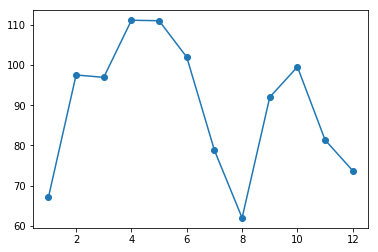

In [15]:
plt.plot(np.arange(1,13), out['HQprecipitation'], 'o-')

In [ ]:
out.to_netcdf('/home/ck/DIR/cornkle/figs/CLOVER/maxMonth_rainfall_gpm_5f3-7f5N.nc')

In [102]:
prcp = out['HQprecipitation'].load()

/home/ck/miniconda3/lib/python3.5/site-packages/dask/compatibility.py:93: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/ck/miniconda3/lib/python3.5/site-packages/toolz/functoolz.py:468: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)


In [104]:
prcp

<xarray.DataArray 'HQprecipitation' (month: 12, lat: 141)>
array([[23.699997, 36.156666, 34.296665, ...,  1.266667,  1.22    ,  1.333333],
       [61.996662, 74.85333 , 65.78    , ...,  6.94    ,  9.706666, 11.496666],
       [62.086666, 60.949997, 68.246666, ...,  2.643333,  5.703333,  3.49    ],
       ...,
       [57.876667, 59.236664, 53.309998, ..., 10.046666, 11.773334, 14.31    ],
       [53.226665, 51.59    , 58.06666 , ...,  1.343333,  1.203333,  1.203333],
       [62.219997, 62.946667, 72.46    , ...,  2.59    ,  2.983333,  2.403333]],
      dtype=float32)
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * lat      (lat) float32 3.95 4.05 4.15 4.25 4.35 ... 17.65 17.75 17.85 17.95

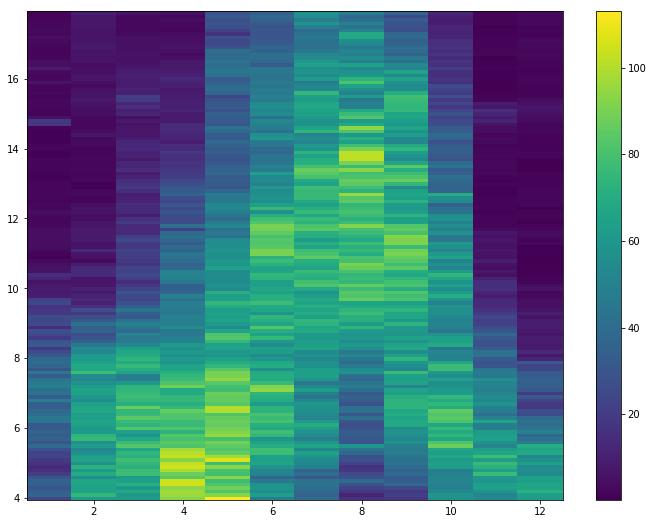

In [109]:
plt.figure(figsize=(12,9))
plt.pcolormesh(np.arange(0.5,13.5,1),prcp.lat, prcp.T)
plt.colorbar()

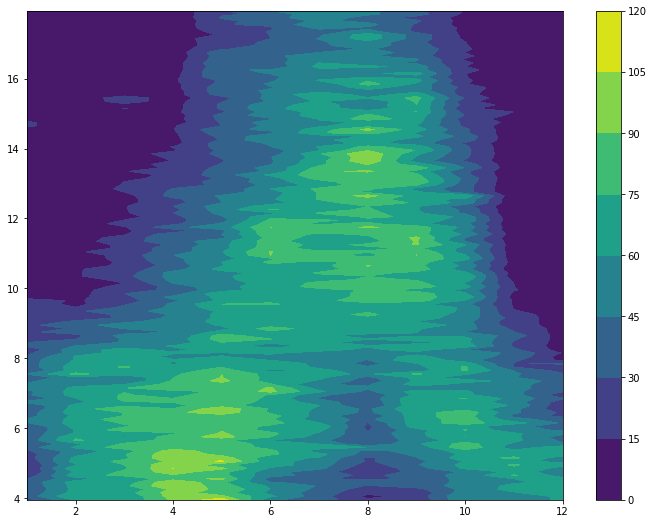

In [111]:
plt.figure(figsize=(12,9))
plt.contourf(np.arange(1,13,1),prcp.lat, prcp.T)
plt.colorbar()
prcp.to_netcdf('/home/ck/DIR/cornkle/figs/CLOVER/maxRain_hov_GPM.nc')

In [54]:
## a clean way of plotting - use matplotlib functions directly:

def draw_map(ax, data, lon, lat, l1, l2, nb,title=None,  text=None, mask_sig=None, quiver=None, contour=None, contour2=None, cbar_label=None,cmap=None):
    #mapp = ax.contourf(lon, lat, data, **kwargs)  # this is the actual plot
    nb_lev = nb
    cmapp = uplot.discrete_cmap(nb_lev, base_cmap=cmap)

#     mapp = ax.pcolormesh(np.arange(0.5,13,1), lat,data
#                           ,cmap=cmapp, vmin=l1, vmax=l2)
    
    mapp = ax.contourf(np.arange(1,13,1), lat,data, levels=np.round(np.linspace(l1,l2,nb),1), cmap=cmap )

    #cbar = plt.colorbar(mapp, ticks=np.linspace(l1,l2,nb_lev+1))
    cbar = plt.colorbar(mapp)
    plt.title(title)
    plt.text(0.03,0.85, text, transform=ax.transAxes, fontsize=14)
    ax.axhline(8.5, linestyle='dashed')
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.pcolormesh(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        cs = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        plt.clabel(cs, inline=1, fontsize=8, fmt="%1.1f")
        
    if contour2 is not None:
        cs = ax.contour(contour2['x'], contour2['y'], contour2['data'], levels=contour2['levels'], colors=contour2['color'], linewidths=0.5 )
        plt.clabel(cs, inline=1, fontsize=8, fmt="%1.1f")
    
#     ax.coastlines()   ## adds coastlines
#     # Gridlines
#     xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
#     xl.xlabels_top = False   ## labels off
#     xl.ylabels_right = False
#     plt.title(title)
#     # Countries
#     ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
   # cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)   

In [12]:
plt.contourf(np.arange(1,13,1),means.lat.values,means['HQprecipitation'].values.T[:,0:-1])
plt.colorbar()

NameError: name 'means' is not defined

In [60]:
np.arange(1,14,1).shape

(13,)

TypeError: Length of x must be number of columns in z.

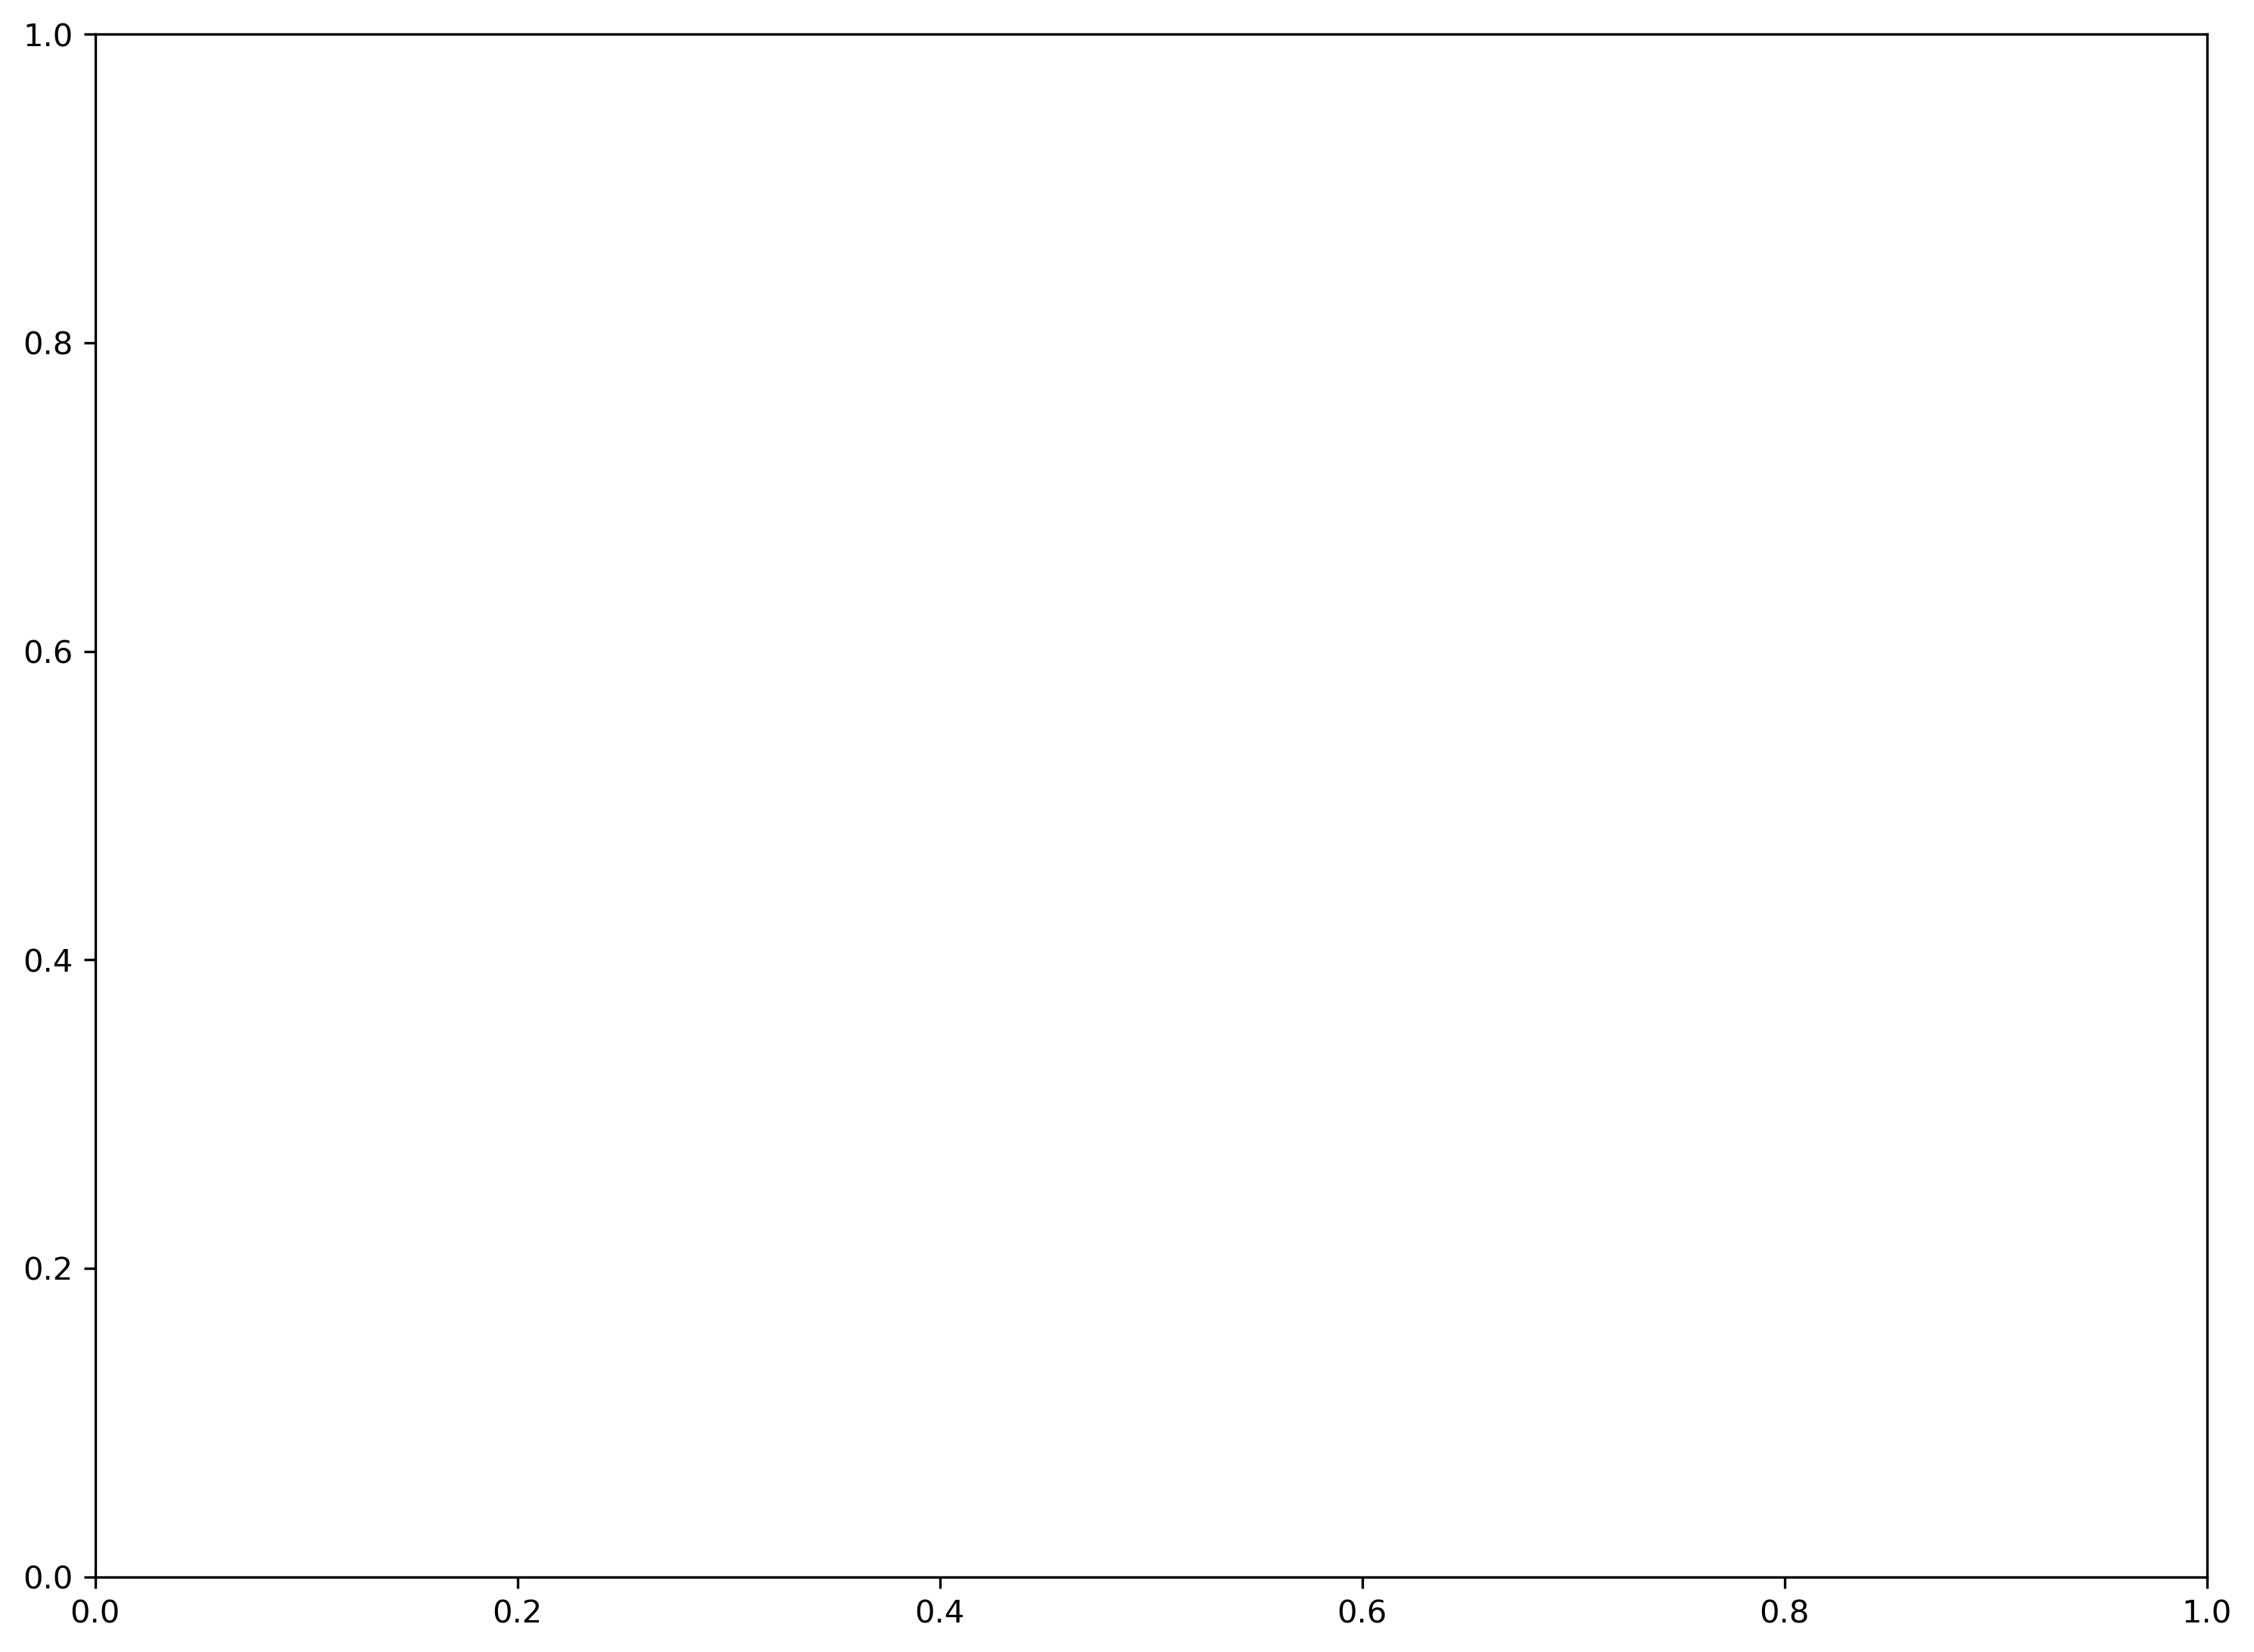

In [56]:
f = plt.figure(figsize=(12,9), dpi=300)
ax = f.add_subplot(111)
draw_map(ax,means['HQprecipitation'].values.T , np.arange(1,14,1), means.lat.values, 20, 370,15, cmap='Blues',  \
         title='Precipitation ', text='(a)', cbar_label='mm day$^{-1}$')
# draw_map(ax, mean.values.T, mean.month, mean.lat, -68, -60, 10, cmap='Blues_r',  \
#          title=r"Average MCS temperature | $\Delta \theta_e$", text='(b)', contour2=contour2, cbar_label='K')